- 阿里云供应链大赛比赛链接 https://tianchi.aliyun.com/competition/entrance/531934/information  
- 记录笔记 https://joyspace.jd.com/page/oWnUboNNUcrK43d99RG1  
- Code https://coding.jd.com/zhunian1/supply_demand_forecast/

- ref:   
1.https://github.com/mlpotter/Transformer_Time_Series  
2.https://zhuanlan.zhihu.com/p/391337035  

In [1]:
!python --version

Python 3.8.8


In [4]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
import os
import platform
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import xgboost as xgb
from xgboost import plot_importance
import pickle

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',100)

In [5]:
demand_train_A = pd.read_csv('../dataset/demand_train_A.csv')
demand_test_A = pd.read_csv('../dataset/demand_test_A.csv')
geo_topo = pd.read_csv('../dataset/geo_topo.csv')
inventory_info_A = pd.read_csv('../dataset/inventory_info_A.csv')
product_topo = pd.read_csv('../dataset/product_topo.csv')
weight_A = pd.read_csv('../dataset/weight_A.csv')

# 1. 特征工程
- 1.1 日期处理（天数补齐）
- 1.2 处理geography_level、product_level多级别特征
- 1.3 使用qty滑窗添加新特征：last14max、last14min、last14std、last14mean、last14median
- 1.4 过去14天下，在同geography与product的qty 资源使用量。

## 1.1 日期处理 （天数补齐）

In [6]:
first_dt = pd.to_datetime("20180604")  
last_dt = pd.to_datetime("20210301")  # 用来限定使用的是历史数据而不是未来数据
start_dt = pd.to_datetime("20210301")  # 用来划定预测的针对test的起始时间
end_dt = pd.to_datetime("20210607")  # 预测需求的截止时间

demand_train_A["ts"] = demand_train_A["ts"].apply(lambda x: pd.to_datetime(x))
demand_train_A.drop(['Unnamed: 0'],axis=1,inplace=True)

demand_test_A["ts"] = demand_test_A["ts"].apply(lambda x: pd.to_datetime(x))
demand_test_A.drop(['Unnamed: 0'],axis=1,inplace=True)

dataset = pd.concat([demand_train_A, demand_test_A])

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346768 entries, 0 to 61935
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unit             346768 non-null  object        
 1   ts               346768 non-null  datetime64[ns]
 2   qty              346768 non-null  float64       
 3   geography_level  346768 non-null  object        
 4   geography        346768 non-null  object        
 5   product_level    346768 non-null  object        
 6   product          346768 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 21.2+ MB


In [ ]:
# 删除掉出现 qty中出现负值的样本，这部分样本数值不对
dataset = dataset[~(dataset.qty < 0)]
print(np.isnan(dataset['qty']).any())
print(np.isinf(dataset['qty']).any())

In [ ]:
dataset.info()

In [ ]:
# unit count
dataset.unit.value_counts()

In [ ]:
np.sort(dataset.qty.values)

In [ ]:
all_date = (dataset.ts.max()-dataset.ts.min()).days + 1
print("样本统计的天数：", all_date)  # Unit 的 天数

# 所有Unit都补全 all_date天的数据
cols = dataset.columns
trainalldate = pd.DataFrame()

for unit in dataset.unit.drop_duplicates():
    tmppd = pd.DataFrame(index=pd.date_range(first_dt, periods=all_date))
    tmppd['unit'] = unit
    tmppd = tmppd.reset_index()
    tmppd.columns = ['ts','unit']
    tmppd = pd.merge(left = tmppd,right = dataset[dataset.unit == unit],how = 'left',on = ['ts','unit']
        )
    #tmppd.fillna(value={'qty':-1},inplace=True)
    #tmppd.fillna(value={'qty':-1},method='bfill',inplace=True)
    trainalldate = pd.concat([trainalldate, tmppd])


In [ ]:
# unit count
trainalldate.unit.value_counts()

In [ ]:
# 不完整的数据
sns.set(rc={'figure.figsize':(25,8)})
sns.lineplot(y =trainalldate[trainalldate.unit == '9b8f48bacb1a63612f3a210ccc6286cc'].qty,
             x =trainalldate[trainalldate.unit == '9b8f48bacb1a63612f3a210ccc6286cc'].ts)

In [ ]:
# 不完整的数据
sns.set(rc={'figure.figsize':(25,8)})
sns.lineplot(y =trainalldate[trainalldate.unit == '7d9cbb373fddba4ce2cddcec96bccbeb'].qty,
             x =trainalldate[trainalldate.unit == '7d9cbb373fddba4ce2cddcec96bccbeb'].ts)

In [ ]:
trainalldate[trainalldate.unit == '7d9cbb373fddba4ce2cddcec96bccbeb']

针对这个 unit:7d9cbb373fddba4ce2cddcec96bccbeb 单元，补齐所有的时间NaN，绘图中空值没有体现出来。

In [ ]:
# 添加 year, month, day 日期特征
trainalldate['year'] = trainalldate['ts'].dt.year
trainalldate['month'] = trainalldate['ts'].dt.month
trainalldate['day'] = trainalldate['ts'].dt.day
trainalldate['week'] = trainalldate['ts'].dt.weekday
trainalldate.info()

## 1.2 处理geography_level、product_level多级别特征

In [ ]:
trainalldate = trainalldate.drop(['geography_level','product_level'],axis = 1)
trainalldate = pd.merge(trainalldate, geo_topo, how='left', left_on = 'geography', right_on = 'geography_level_3')
trainalldate = pd.merge(trainalldate, product_topo, how='left', left_on = 'product', right_on = 'product_level_2')
trainalldate = trainalldate.drop(['geography','product'],axis = 1)
trainalldate.head()

In [ ]:
# labelEncoder
encoder = ['geography_level_1','geography_level_2','geography_level_3','product_level_1','product_level_2']
# add feature
# unit_all = ['unit_geo', 'unit_pro', 'geo_pro']
unit_all = [ 'unit_pro', 'geo_pro']

# trainalldate["unit_geo"] = trainalldate.apply(lambda x: f"{x['unit']}_{x['geography_level_3']}", axis=1)
trainalldate["unit_pro"] = trainalldate.apply(lambda x: f"{x['unit']}_{x['product_level_2']}", axis=1)
trainalldate["geo_pro"] = trainalldate.apply(lambda x: f"{x['geography_level_3']}_{x['product_level_2']}", axis=1)

lbl = LabelEncoder()
for feat in encoder+unit_all:
    lbl.fit(trainalldate[feat])
    trainalldate[feat] = lbl.transform(trainalldate[feat])


In [ ]:
# add the weight of each units
trainalldate = pd.merge(trainalldate, weight_A, left_on = 'unit', right_on = 'unit')
trainalldate = trainalldate.drop(['Unnamed: 0'],axis = 1)

In [ ]:
# unit to unit_id
enc_unit = lbl.fit(trainalldate['unit'])
trainalldate['unit'] = enc_unit.transform(trainalldate['unit'])
trainalldate.head()

# unit id -> 反编码
# enc_unit.inverse_transform(trainalldate['unit'])

In [ ]:
# save to pkl
# trainalldate.to_csv('../output/trainalldate.csv', index=False)
import pickle

with open("../output/trainalldate.pkl", 'wb') as fo: 
    pickle.dump(trainalldate, fo)

## 1.3 使用qty滑窗添加新特征：last14max、last14min、last14std、last14mean、last14median、last14sum
Ref: https://zhuanlan.zhihu.com/p/101284491

In [ ]:
with open("../output/trainalldate.pkl", 'rb') as fo:     # 读取pkl文件数据
    trainalldate = pickle.load(fo, encoding='bytes')

trainalldate["ts"] = trainalldate["ts"].apply(lambda x: pd.to_datetime(x))
print(trainalldate.shape)
trainalldate.head()

In [ ]:
trainalldate.info()

In [ ]:
def qtyGetKvalue(data, k):
    '''
    k: the last k-ist value of data
    '''
    data = data.sort_values(
        by=['ts'], ascending=True).reset_index(drop=True)
    data = data.iloc[len(data) - k, -1] if len(data) >= k else np.NaN
    return data

def qtyNewFeature(df, ts = np.nan):
    newdataset = pd.DataFrame()
    
    timeline = pd.date_range(df.ts.min(), df.ts.max())
    for t in timeline:
        
        # today
        ts = df[df.ts == t]
        
        # last 14 day information ... 
        rdd = df[(df.ts >= t - datetime.timedelta(14)) & (df.ts < t)]
        
        last14max_dict = rdd.groupby('unit')['qty'].max().to_dict()
        last14min_dict = rdd.groupby('unit')['qty'].min().to_dict()
        last14std_dict = rdd.groupby('unit')['qty'].std().to_dict()
        last14mean_dict = rdd.groupby('unit')['qty'].mean().to_dict()
        last14median_dict = rdd.groupby('unit')['qty'].median().to_dict()
        last14sum_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        
        ts['last14max'] = ts['unit'].map(last14max_dict)
        ts['last14min'] = ts['unit'].map(last14min_dict)
        ts['last14std'] = ts['unit'].map(last14std_dict)
        ts['last14mean'] = ts['unit'].map(last14mean_dict)
        ts['last14median'] = ts['unit'].map(last14median_dict)
        ts['last14sum'] = ts['unit'].map(last14sum_dict)
        
        
        # last 7 day information ..
        rdd = df[(df.ts >= t - datetime.timedelta(7)) & (df.ts < t)]
        
        last7max_dict = rdd.groupby('unit')['qty'].max().to_dict()
        last7min_dict = rdd.groupby('unit')['qty'].min().to_dict()
        last7std_dict = rdd.groupby('unit')['qty'].std().to_dict()
        last7mean_dict = rdd.groupby('unit')['qty'].mean().to_dict()
        last7median_dict = rdd.groupby('unit')['qty'].median().to_dict()
        last7sum_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        
        ts['last7max'] = ts['unit'].map(last7max_dict)
        ts['last7min'] = ts['unit'].map(last7min_dict)
        ts['last7std'] = ts['unit'].map(last7std_dict)
        ts['last7mean'] = ts['unit'].map(last7mean_dict)
        ts['last7median'] = ts['unit'].map(last7median_dict)
        ts['last7sum'] = ts['unit'].map(last7sum_dict)
        
        
        # last 3 day information ...
        rdd = df[(df.ts >= t - datetime.timedelta(3)) & (df.ts < t)]
        
        last3max_dict = rdd.groupby('unit')['qty'].max().to_dict()
        last3min_dict = rdd.groupby('unit')['qty'].min().to_dict()
        last3std_dict = rdd.groupby('unit')['qty'].std().to_dict()
        last3mean_dict = rdd.groupby('unit')['qty'].mean().to_dict()
        last3median_dict = rdd.groupby('unit')['qty'].median().to_dict()
        last3sum_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        last3value_dict = rdd.groupby('unit')['ts', 'qty'].apply(qtyGetKvalue, k=3).to_dict()
        
        ts['last3max'] = ts['unit'].map(last3max_dict)
        ts['last3min'] = ts['unit'].map(last3min_dict)
        ts['last3std'] = ts['unit'].map(last3std_dict)
        ts['last3mean'] = ts['unit'].map(last3mean_dict)
        ts['last3median'] = ts['unit'].map(last3median_dict)
        ts['last3sum'] = ts['unit'].map(last3sum_dict)
        ts['last3value'] = ts['unit'].map(last3value_dict)
        
        
        # last 1、2 day information ..
        rdd = df[(df.ts >= t - datetime.timedelta(1)) & (df.ts < t)]
        last1value_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        ts['last1value'] = ts['unit'].map(last1value_dict)
        
        rdd = df[(df.ts >= t - datetime.timedelta(2)) & (df.ts < t)]
        last2mean_dict = rdd.groupby('unit')['qty'].mean().to_dict()
        last2sum_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        last2value_dict = rdd.groupby('unit')['ts', 'qty'].apply(qtyGetKvalue, k=2).to_dict()
        
        ts['last2mean'] = ts['unit'].map(last2mean_dict)
        ts['last2sum'] = ts['unit'].map(last2sum_dict)
        ts['last2value'] = ts['unit'].map(last2value_dict)
        
        newdataset = pd.concat([newdataset, ts])
        if t.month == 1 and t.day == 1:
            print(t)
    return newdataset

# # 适合样本量比较少的训练集
# def qtyNewFeaturelow(df, ts = np.nan):
#     df['last14max'] = np.nan
#     df['last14min'] = np.nan
#     df['last14std'] = np.nan
#     df['last14mean'] = np.nan
#     df['last14median'] = np.nan
#     df['last14sum'] = np.nan
    
#     for i in range(df.shape[0]):
#         currset = df.iloc[i:i+1,:]
        
#         unit = currset['unit'].values[0]
#         ts = pd.to_datetime(currset['ts'].values[0])
#         last14set = df[(df.unit == unit) & (df.ts >= ts - datetime.timedelta(14)) & (df.ts < ts)]

#         df.loc[currset.index,'last14max'] = np.max(last14set['qty'])
#         df.loc[currset.index,'last14min'] = np.min(last14set['qty'])
#         df.loc[currset.index,'last14std'] = np.std(last14set['qty'])
#         df.loc[currset.index,'last14mean'] = np.mean(last14set['qty'])
#         df.loc[currset.index,'last14median'] = np.median(last14set['qty'])
#         df.loc[currset.index,'last14sum'] = np.sum(last14set['qty'])
#         # print(currset.index)
#     return df

In [ ]:
traindataset = qtyNewFeature(trainalldate)

In [ ]:
traindataset.info()

In [ ]:
traindataset.info()

In [ ]:
# train1q = qtyNewFeaturelow(trainalldate[:1000])
# train1q.head()

In [ ]:
## PRINT...

# today
t = pd.to_datetime("20180606")
# ts = trainalldate[trainalldate.ts == pd.to_datetime("20210601")]
rdd = trainalldate[(trainalldate.ts >= t - datetime.timedelta(2)) & (trainalldate.ts < t)]

# # last 14 day information ... 
# rdd = df[(df.ts >= t - datetime.timedelta(14)) & (df.ts < t)]
rdd.groupby('unit')['ts', 'qty'].apply(qtyGetKvalue, k=3)

## 1.4 过去14天下，在同geography与product的qty 资源使用量。

In [ ]:
def geoproNewFeature(df):
    newdataset = pd.DataFrame()
    
    timeline = pd.date_range(df.ts.min(), df.ts.max())
    for t in timeline:
        ts = df[df.ts == t]
        rdd = df[(df.ts >= t - datetime.timedelta(14)) & (df.ts < t)]
        
        # grouby for calculate mean&median
        geo1mean14_dict = rdd.groupby('geography_level_1')['qty'].mean().to_dict()
        geo2mean14_dict = rdd.groupby('geography_level_2')['qty'].mean().to_dict()
        geo3mean14_dict = rdd.groupby('geography_level_3')['qty'].mean().to_dict()
        pro1mean14_dict = rdd.groupby('product_level_1')['qty'].mean().to_dict()
        pro2mean14_dict = rdd.groupby('product_level_2')['qty'].mean().to_dict()
        geo1median14_dict = rdd.groupby('geography_level_1')['qty'].median().to_dict()
        geo2median14_dict = rdd.groupby('geography_level_2')['qty'].median().to_dict()
        geo3median14_dict = rdd.groupby('geography_level_3')['qty'].median().to_dict()
        pro1median14_dict = rdd.groupby('product_level_1')['qty'].median().to_dict()
        pro2median14_dict = rdd.groupby('product_level_2')['qty'].median().to_dict()
        
        # map to df
        ts['geo1mean14'] = ts['geography_level_1'].map(geo1mean14_dict)
        ts['geo2mean14'] = ts['geography_level_2'].map(geo2mean14_dict)
        ts['geo3mean14'] = ts['geography_level_3'].map(geo3mean14_dict)
        ts['pro1mean14'] = ts['product_level_1'].map(pro1mean14_dict)
        ts['pro2mean14'] = ts['product_level_2'].map(pro2mean14_dict)
        
        ts['geo1median14'] = ts['geography_level_1'].map(geo1median14_dict)
        ts['geo2median14'] = ts['geography_level_2'].map(geo2median14_dict)
        ts['geo3median14'] = ts['geography_level_3'].map(geo3median14_dict)
        ts['pro1median14'] = ts['product_level_1'].map(pro1median14_dict)
        ts['pro2median14'] = ts['product_level_2'].map(pro2median14_dict)
        

        
        
#         # grouby rdd for calculate mean&median and transform DataFrame
#         ts['geo1mean14'] = rdd.groupby('geography_level_1')['qty'].transform('mean')
#         ts['geo2mean14'] = rdd.groupby('geography_level_2')['qty'].transform('mean')
#         ts['geo3mean14'] = rdd.groupby('geography_level_3')['qty'].transform('mean')
#         ts['pro1mean14'] = rdd.groupby('product_level_1')['qty'].transform('mean')
#         ts['pro2mean14'] = rdd.groupby('product_level_2')['qty'].transform('mean')
#         ts['geo1median14'] = rdd.groupby('geography_level_1')['qty'].transform('median')
#         ts['geo2median14'] = rdd.groupby('geography_level_2')['qty'].transform('median')
#         ts['geo3median14'] = rdd.groupby('geography_level_3')['qty'].transform('median')
#         ts['pro1median14'] = rdd.groupby('product_level_1')['qty'].transform('median')
#         ts['pro2median14'] = rdd.groupby('product_level_2')['qty'].transform('median')
        
        newdataset = pd.concat([newdataset, ts])
        # print(t)
        if t.month == 1:
            print(t)
    return newdataset

In [ ]:
traindatasetall = geoproNewFeature(traindataset)
traindatasetall

In [ ]:
# traindatasetall.to_csv("../output/traindatasetall.csv", index=False)
import pickle

with open("../output/traindataset.pkl", 'wb') as fo: 
    pickle.dump(traindatasetall, fo)

In [ ]:
traindatasetall.to_csv("../output/traindatasetall.csv", index=False)

In [ ]:
traindatasetall.info()

In [ ]:
currset = trainalldate.iloc[50:51,:]
unit = currset['unit'].values[0]
ts = pd.to_datetime(currset['ts'].values[0])

In [ ]:
trainalldate[(trainalldate.ts >= ts - datetime.timedelta(14)) & (trainalldate.ts < ts)].ts.value_counts()

In [ ]:
currset

In [ ]:
rdd = trainalldate[(trainalldate.ts >= ts - datetime.timedelta(14)) & (trainalldate.ts < ts)]
rdd.groupby('geography_level_1')['qty'].mean().to_dict()

In [ ]:
dict_ = rdd.groupby('geography_level_1')['qty'].mean().to_dict()

In [ ]:
rdd.groupby('geography_level_2')['qty'].mean().to_dict()

# 2. 数据分析
- 2.1 日期与库存销量qty之间的关系
- 2.2 weight 特征与其他指标之间的分析
- 2.3 geography和product与库存销量qty之间的关系

## 2.1 日期与库存销量qty之间的关系
- 1.哪月库存销量最佳, 随着日期变化，库存均销量的变化趋势是怎么样的?
- 2.一个月中哪个天的库存销量是最好的？

In [ ]:
# 统计2020-1-1 至 2021-1-1 日之间销量情况
l = pd.to_datetime("20200101")  
r = pd.to_datetime("20210101")
rdd = trainalldate[(trainalldate.ts >= l) & (trainalldate.ts < r)]

In [ ]:
print(len(rdd.ts.unique()),  len(rdd.unit.unique()))  # the day and all the unit

In [ ]:
rdd.groupby('month')['qty'].mean().plot.line()
rdd.groupby('month')['qty'].mean()

In [ ]:
rdd.groupby('week')['qty'].mean().plot.line()
rdd.groupby('week')['qty'].mean()

In [ ]:
rdd.groupby('day')['qty'].mean().plot.line()
rdd.groupby('day')['qty'].mean()

In [ ]:
# the high day is 8
# count the 8 of all year
daysYear = pd.Series(pd.date_range(start=l, end=r))
weeks = list(map(lambda x:x.day_name(), filter(lambda x:x.day == 8, daysYear)))
print(list(filter(lambda x:x.day == 8, daysYear)))
print(weeks)

In [ ]:
import collections
a = collections.Counter(weeks)
plt.bar(*zip(*a.items()))
plt.show()

## 2.2 weight 特征分析

In [ ]:
trainalldate.info()

In [ ]:
# weight num and unit
trainalldate.groupby('weight')['unit'].count()

总共有131种不同的weight，其中最多weight == 0.001

In [ ]:
# the relationshape of weight an unit
# pd.crosstab(trainalldate.unit,trainalldate.weight,margins=True).style.background_gradient(cmap='summer_r')

In [ ]:
# 统计出不同weight下，qty库存使用量的均值
trainalldate.groupby('weight')['qty'].mean().plot.bar()

In [ ]:
trainalldate.groupby('weight')['qty'].get_group(0.943)

## 2.3 geography和product与库存销量qty之间的关系


In [ ]:
# weight num and unit
trainalldate.info()

In [ ]:
# 统计出不同weight下，qty库存使用量的均值
trainalldate.groupby('geography_level_3')['qty'].mean().plot.bar()

In [ ]:
dict(trainalldate.groupby('geography_level_3')['unit'].count())

In [ ]:
# 统计出不同weight下，qty库存使用量的均值
trainalldate.groupby('product_level_2')['qty'].mean().plot.bar()

# 3. 模型训练

- 1 Xgboost
- 2.LightGBM
- 3.autox
- 4.JDCross
- ref  
https://github.com/PENGZhaoqing/TimeSeriesPrediction  
https://github.com/gabrielpreda/Kaggle/blob/master/SantanderCustomerTransactionPrediction/starter-code-saving-and-loading-lgb-xgb-cb.py

## 3.1 Xgboost 

In [ ]:
# load traindataset
with open("../output/traindataset.pkl", 'rb') as fo:     # 读取pkl文件数据
    traindataset = pickle.load(fo, encoding='bytes')

traindataset["ts"] = traindataset["ts"].apply(lambda x: pd.to_datetime(x))
print(traindataset.shape)
traindataset.head()

In [ ]:
traindataset.info()

In [ ]:
# features
sparse_features = ['unit', 'year', 'month', 'day', 'week', 'geography_level_1', 'geography_level_2', 'geography_level_3', 
                   'product_level_1', 'product_level_2', 'unit_pro', 'geo_pro']
dense_features = ['weight',
       'last14max', 'last14min', 'last14std', 'last14mean', 'last14median',
       'last14sum', 'last7max', 'last7min', 'last7std', 'last7mean',
       'last7median', 'last7sum', 'last3max', 'last3min', 'last3std',
       'last3mean', 'last3median', 'last3sum', 'last3value', 'last1value', 'last2mean',
       'last2sum', 'last2value', 'geo1mean14', 'geo2mean14', 'geo3mean14', 'pro1mean14',
       'pro2mean14', 'geo1median14', 'geo2median14', 'geo3median14',
       'pro1median14', 'pro2median14']

target = ['qty']

In [ ]:
# traindataset[:100].loc[~traindataset[:100]['geo1mean14'].isnull()]
# traindataset[np.isnan(traindataset['qty'].values)]
# traindataset['qty'][np.isinf(traindataset['qty'])] = 0.0 

# 替换空值，和选择大于0的数据
traindataset = traindataset.dropna(subset=["qty"])
traindataset = traindataset[traindataset["qty"] >= 0]
traindataset.shape

In [ ]:
print(np.isnan(traindataset['qty']).any())
print(np.isinf(traindataset['qty']).any())

In [ ]:
# qty 进行转化
plt.figure(figsize=(18, 10))
fig, axes = plt.subplots(nrows=2, ncols=1)
traindataset['qty'].hist(bins=100, ax=axes[0])
traindataset['qty'] = np.log(traindataset['qty'] + 1)  # 
traindataset['qty'].hist(bins=100, ax=axes[1])
plt.show()

In [ ]:
## 3.1 xgboost
traindataset = traindataset.dropna(axis=0, how='any')
train = traindataset[traindataset.ts <= pd.to_datetime("20210301")]
test = traindataset[traindataset.ts > pd.to_datetime("20210301")]

X_train, X_test, y_train, y_test = train[sparse_features + dense_features], test[sparse_features + dense_features], train[target], test[target]
print('The shape of X_train:{}'.format(X_train.shape))
print('The shape of X_test:{}'.format(X_test.shape))

In [ ]:
# ## 3.1 xgboost
# from sklearn.model_selection import train_test_split


# traindataset = traindataset.dropna(axis=0, how='any')
# X_train, X_test, y_train, y_test = train_test_split(traindataset[sparse_features + dense_features], traindataset[target], test_size=0.20)

# print('The shape of X_train:{}'.format(X_train.shape))
# print('The shape of X_test:{}'.format(X_test.shape))

In [ ]:
params = {
    'learning_rate': 0.25,
    'n_estimators': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'max_depth': 12,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'gamma': 0
}

# dtrain = xgb.DMatrix(X, label=y, feature_names=x)

bst = xgb.XGBRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                             booster='gbtree', objective='reg:linear', n_jobs=-1, subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'], random_state=0,
                             max_depth=params['max_depth'], gamma=params['gamma'],
                             min_child_weight=params['min_child_weight'], reg_alpha=params['reg_alpha'])
bst.fit(X_train.values, y_train.values)

In [ ]:
pre = bst.predict(X_test.values)

# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# mape = mape(np.expm1(y_test.reshape(-1)), np.expm1(pre))
# print("MAPE is: {}".format(mape))

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_norm = mean_absolute_error(y_test.values, pre)  # 归一化后的值
mae = mean_absolute_error(np.expm1(y_test.values), np.expm1(pre))


rmse = np.sqrt(mean_squared_error(np.expm1(y_test.values), np.expm1(pre)))

print("mae:",mae_norm)
print("mae:",mae)
print("rmse:",rmse)

<Figure size 1296x720 with 0 Axes>

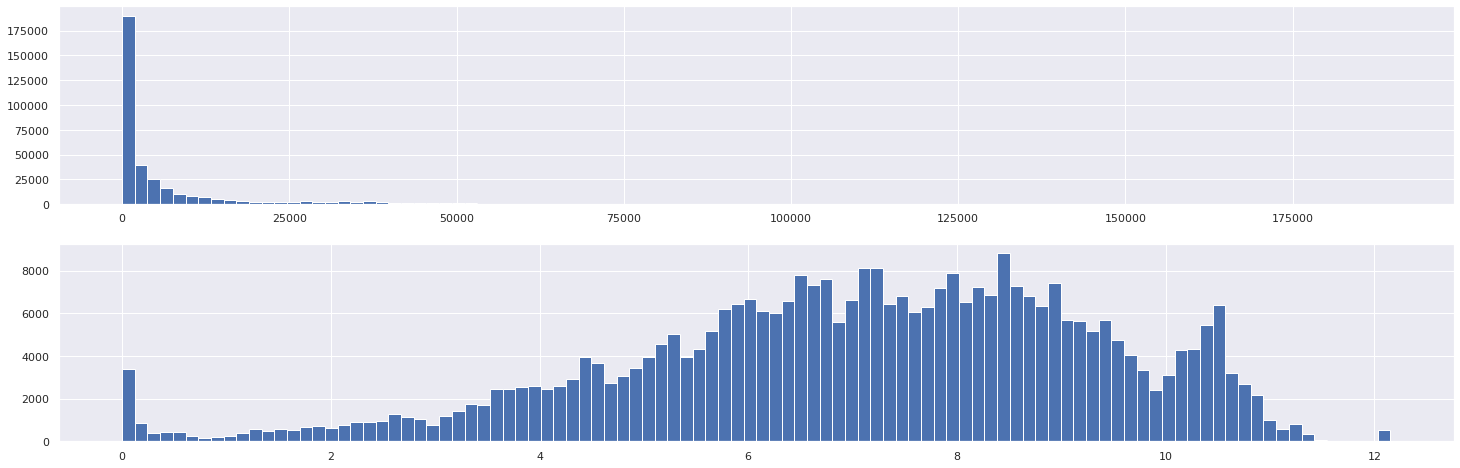

In [101]:
# qty 进行转化
plt.figure(figsize=(18, 10))
fig, axes = plt.subplots(nrows=2, ncols=1)
traindataset['qty'].hist(bins=100, ax=axes[0])
traindataset['qty'] = np.log(traindataset['qty'] + 1)  # 
traindataset['qty'].hist(bins=100, ax=axes[1])
plt.show()

In [119]:
## 3.1 xgboost
traindataset = traindataset.dropna(axis=0, how='any')
train = traindataset[traindataset.ts <= pd.to_datetime("20210301")]
test = traindataset[traindataset.ts > pd.to_datetime("20210301")]

X_train, X_test, y_train, y_test = train[sparse_features + dense_features], test[sparse_features + dense_features], train[target], test[target]
print('The shape of X_train:{}'.format(X_train.shape))
print('The shape of X_test:{}'.format(X_test.shape))

The shape of X_train:(281489, 46)
The shape of X_test:(61936, 46)


In [103]:
# ## 3.1 xgboost
# from sklearn.model_selection import train_test_split


# traindataset = traindataset.dropna(axis=0, how='any')
# X_train, X_test, y_train, y_test = train_test_split(traindataset[sparse_features + dense_features], traindataset[target], test_size=0.20)

# print('The shape of X_train:{}'.format(X_train.shape))
# print('The shape of X_test:{}'.format(X_test.shape))

The shape of X_train:(274740, 46)
The shape of X_test:(68685, 46)


In [134]:
params = {
    'learning_rate': 0.25,
    'n_estimators': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'max_depth': 12,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'gamma': 0
}

# dtrain = xgb.DMatrix(X, label=y, feature_names=x)

bst = xgb.XGBRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                             booster='gbtree', objective='reg:linear', n_jobs=-1, subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'], random_state=0,
                             max_depth=params['max_depth'], gamma=params['gamma'],
                             min_child_weight=params['min_child_weight'], reg_alpha=params['reg_alpha'])
bst.fit(X_train.values, y_train.values)

[15:50:29] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=-1,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [135]:
pre = bst.predict(X_test.values)

# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# mape = mape(np.expm1(y_test.reshape(-1)), np.expm1(pre))
# print("MAPE is: {}".format(mape))

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_norm = mean_absolute_error(y_test.values, pre)  # 归一化后的值
mae = mean_absolute_error(np.expm1(y_test.values), np.expm1(pre))


rmse = np.sqrt(mean_squared_error(np.expm1(y_test.values), np.expm1(pre)))

print("mae:",mae_norm)
print("mae:",mae)
print("rmse:",rmse)

mae: 0.0169853220505046
mae: 56.53049660927482
rmse: 232.05474656993192


In [31]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# mape = mape(np.expm1(y_test.reshape(-1)), np.expm1(pre))
# print("MAPE is: {}".format(mape))

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_norm = mean_absolute_error(y_test.values, pre)  # 归一化后的值
mae = mean_absolute_error(np.expm1(y_test.values), np.expm1(pre))


rmse = np.sqrt(mean_squared_error(np.expm1(y_test.values), np.expm1(pre)))

print("mae:",mae_norm)
print("mae:",mae)
print("rmse:",rmse)


mae: 0.017451066539189278
mae: 53.12144455181579
rmse: 166.15749286109192


In [136]:
i = 1000
booster = bst.get_booster()
dtrain = xgb.DMatrix(np.array([X_train.iloc[i, :].values]))
print('Predicted probability: ' + str(booster.predict(dtrain)))
print('Predicted raw value: {}\n'.format(
    booster.predict(dtrain, output_margin=True)))
contribs = booster.predict(dtrain, pred_contribs=True)
contributions2 = zip(sparse_features + dense_features + ['Bias'], contribs[0])
print('Contributions (sorted by absolute value):\n' + '\n'.join(str(x)
                                                                for x in sorted(contributions2, key=lambda x: abs(x[1]), reverse=True)))
print("Sum of contributions {}".format(
    booster.predict(dtrain, pred_contribs=True).sum()))

Predicted probability: [8.244254]
Predicted raw value: [8.244254]

Contributions (sorted by absolute value):
('Bias', 7.0546613)
('last2mean', 0.7719071)
('last1value', 0.3835022)
('last3mean', 0.17534204)
('last2sum', 0.06704445)
('last3median', -0.064415015)
('last14max', -0.03296701)
('last2value', -0.03294077)
('weight', 0.018288495)
('last3min', -0.015065764)
('last14std', -0.013607538)
('last14min', -0.012635188)
('last7min', -0.012374556)
('last7mean', -0.01132545)
('last7max', 0.010692167)
('last7median', -0.010589252)
('last14sum', -0.008275344)
('last3sum', -0.007773809)
('last14mean', -0.007369822)
('last3max', 0.005856699)
('last3value', -0.0050788736)
('day', -0.004551134)
('pro2mean14', 0.0030447177)
('last7std', -0.002589934)
('last14median', -0.002218429)
('last3std', -0.0021336535)
('geography_level_1', -0.0014696874)
('last7sum', -0.0013770126)
('week', 0.001257011)
('unit', -0.0011221771)
('geo3mean14', 0.0010528992)
('year', -0.0009949913)
('geography_level_3', 0.00

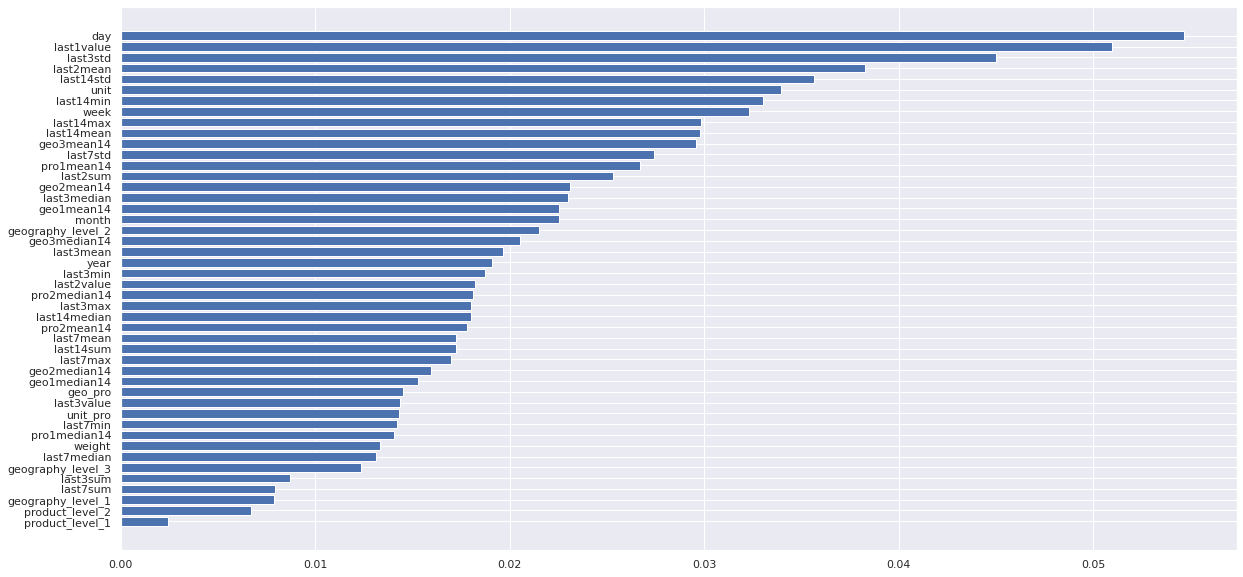

In [137]:
def get_xgb_feat_importances(clf, train_features):

    if isinstance(clf, xgb.XGBModel):
        # clf has been created by calling
        # xgb.XGBClassifier.fit() or xgb.XGBRegressor().fit()
        fscore = clf.get_booster().get_fscore()
    else:
        # clf has been created by calling xgb.train.
        # Thus, clf is an instance of xgb.Booster.
        fscore = clf.get_fscore()
    
    feat_importances = []
    
    for feat, value in zip(fscore.keys(), train_features):
        feat_importances.append({'Feature': value, 'Importance': fscore[feat]})
    
    # for ft, score in fscore.items():
    #     feat_importances.append({'Feature': ft, 'Importance': score})
    feat_importances = pd.DataFrame(feat_importances)
    feat_importances = feat_importances.sort_values(
        by='Importance', ascending=False).reset_index(drop=True)
    # Divide the importances by the sum of all importances
    # to get relative importances. By using relative importances
    # the sum of all importances will equal to 1, i.e.,
    # np.sum(feat_importances['importance']) == 1
    feat_importances['Importance'] /= feat_importances['Importance'].sum()
    # Print the most important features and their importances
    return dict(zip(fscore.keys(), train_features)), feat_importances


f, res = get_xgb_feat_importances(bst, sparse_features + dense_features)

plt.figure(figsize=(20, 10))
plt.barh(range(len(res)), res['Importance'][::-1], tick_label=res['Feature'][::-1])
plt.show()

In [138]:
f

{'f0': 'unit',
 'f1': 'year',
 'f2': 'month',
 'f3': 'day',
 'f4': 'week',
 'f5': 'geography_level_1',
 'f6': 'geography_level_2',
 'f7': 'geography_level_3',
 'f8': 'product_level_1',
 'f9': 'product_level_2',
 'f10': 'unit_pro',
 'f11': 'geo_pro',
 'f12': 'weight',
 'f13': 'last14max',
 'f14': 'last14min',
 'f15': 'last14std',
 'f16': 'last14mean',
 'f17': 'last14median',
 'f18': 'last14sum',
 'f19': 'last7max',
 'f20': 'last7min',
 'f21': 'last7std',
 'f22': 'last7mean',
 'f23': 'last7median',
 'f24': 'last7sum',
 'f25': 'last3max',
 'f26': 'last3min',
 'f27': 'last3std',
 'f28': 'last3mean',
 'f29': 'last3median',
 'f30': 'last3sum',
 'f31': 'last3value',
 'f32': 'last1value',
 'f33': 'last2mean',
 'f34': 'last2sum',
 'f35': 'last2value',
 'f36': 'geo1mean14',
 'f37': 'geo2mean14',
 'f38': 'geo3mean14',
 'f39': 'pro1mean14',
 'f40': 'pro2mean14',
 'f41': 'geo1median14',
 'f42': 'geo2median14',
 'f43': 'geo3median14',
 'f44': 'pro1median14',
 'f45': 'pro2median14'}

<Figure size 1440x720 with 0 Axes>

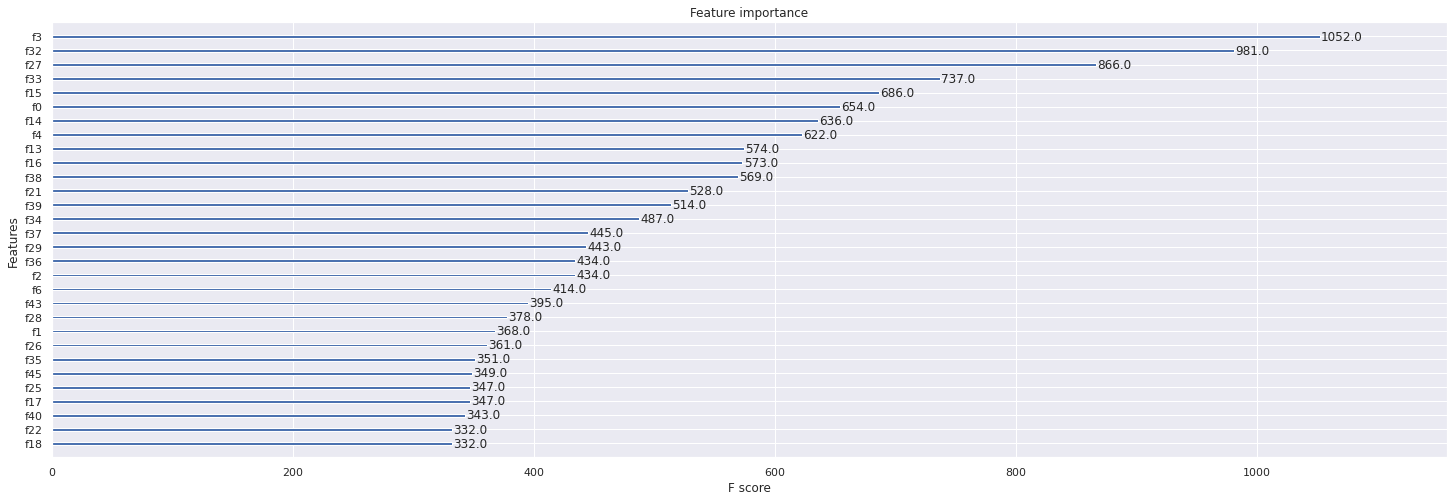

In [139]:
from xgboost import plot_importance

plt.figure(figsize=(20,10))
plot_importance(bst, max_num_features=30)
plt.show()

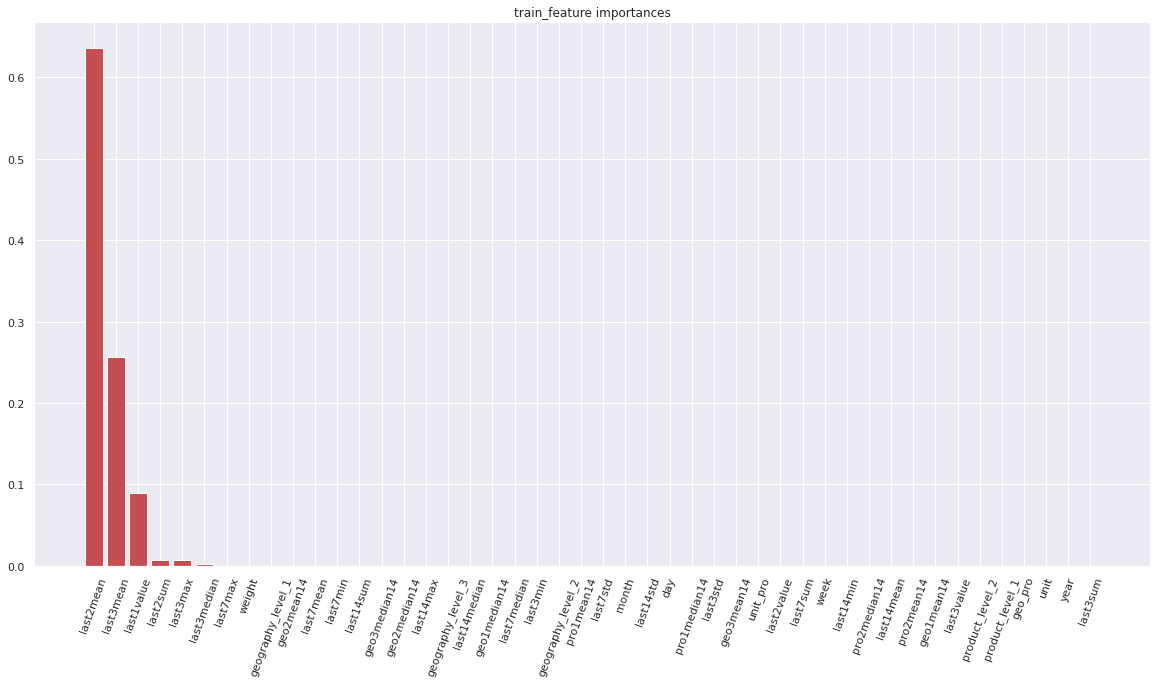

In [140]:

def feature_vis(regressor, train_feature):
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_features = [train_feature[e] for e in indices]
    plt.figure(figsize=(20, 10))
    plt.title("train_feature importances")
    plt.bar(range(len(train_feature)), importances[indices],
            color="r", align="center")
    plt.xticks(range(len(selected_features)), selected_features, rotation=70)
    plt.show()
    

    
feature_vis(bst,  sparse_features + dense_features)


In [141]:
# plot the model result

data = X_test.copy()
data['qty'] = np.expm1(y_test)
data['pre_qty'] = np.expm1(pre)

In [142]:
data.head()

,unit,year,month,day,week,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2,...,geo3mean14,pro1mean14,pro2mean14,geo1median14,geo2median14,geo3median14,pro1median14,pro2median14,qty,pre_qty
1002,386,2021,3,2,1,5,12,11,1,6,...,7709.537254,20193.916072,19104.613245,705.998806,1539.003635,5733.833333,16845.4902,16623.2496,15624.4286,15485.251953
2102,463,2021,3,2,1,0,3,75,1,6,...,13567.202840,20193.916072,19104.613245,2784.529622,4174.833333,4980.000000,16845.4902,16623.2496,40947.1266,40688.589844
3202,273,2021,3,2,1,0,10,7,1,6,...,11241.741821,20193.916072,19104.613245,2784.529622,3385.894911,7220.000000,16845.4902,16623.2496,1820.5290,1813.172241
4302,520,2021,3,2,1,1,11,23,1,6,...,14139.311932,20193.916072,19104.613245,2154.072808,2187.187500,2961.583333,16845.4902,16623.2496,36673.2452,36644.664062
5402,480,2021,3,2,1,7,4,76,1,6,...,7275.798457,20193.916072,19104.613245,1246.500000,1246.500000,3289.083333,16845.4902,16623.2496,16863.3902,16996.164062


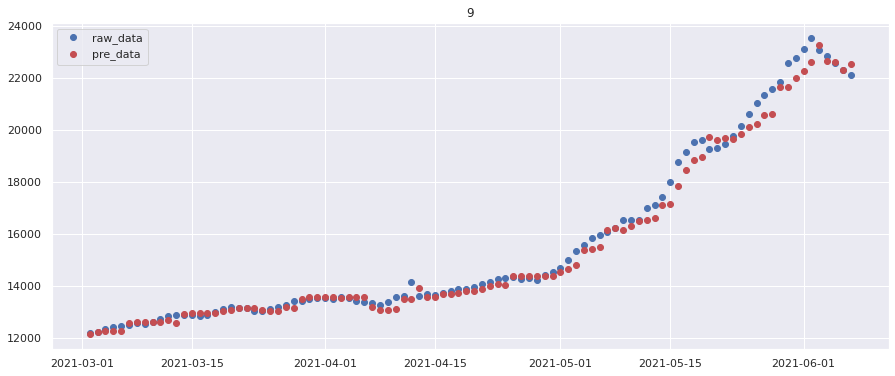

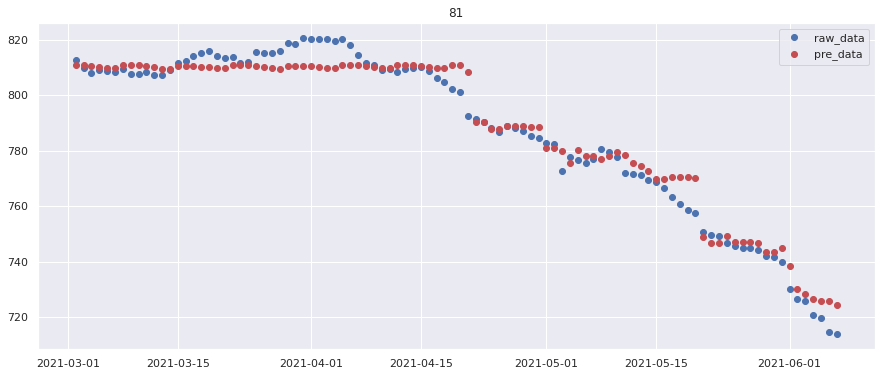

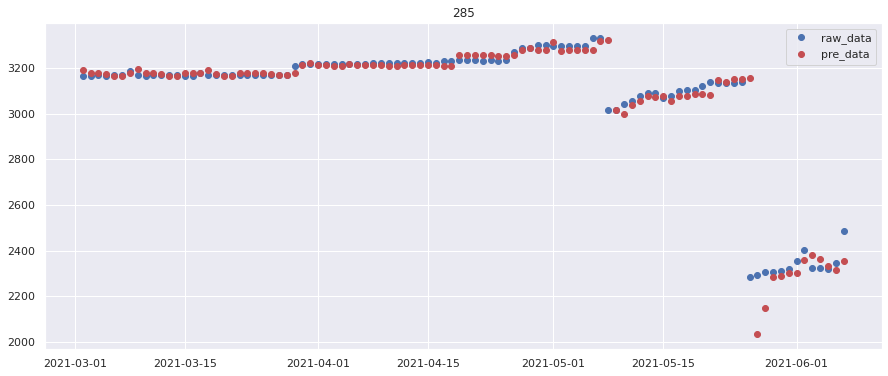

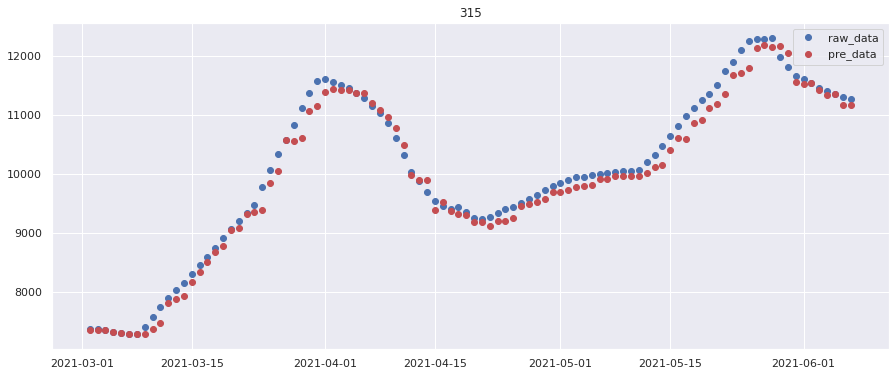

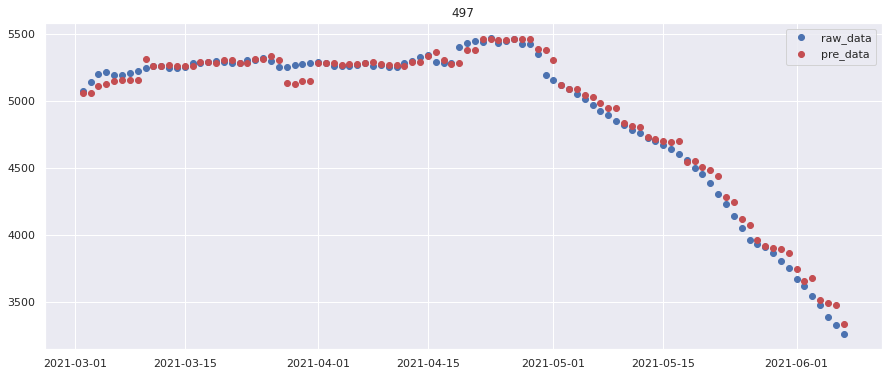

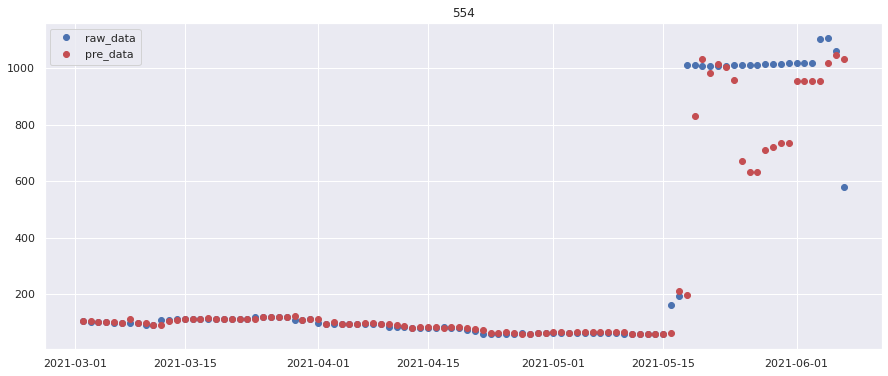

""


In [143]:
def date_trend(data):
    val = data.sort_values(
        by=['year', 'month', 'day'], ascending=True).reset_index(drop=True)
    
    val["date"] = val.apply(lambda x: f"{int(x['year'])}-{int(x['month'])}-{int(x['day'])}", axis=1)
    val["date"] = val["date"].apply(lambda x: pd.to_datetime(x))

    if val.unit.values[0] in [497, 81, 9, 285, 554, 315]:
        plt.figure(figsize=(15, 6))
        l1 = plt.plot(val.date, val['qty'], 'o', label='raw_data')
        l2 = plt.plot(val.date, val['pre_qty'], 'ro', label="pre_data")
        plt.legend()
        # plt.plot(val.date, val['qty'], 'o', val.date, val['pre_qty'], 'ro')
        plt.title(str(val.unit.values[0]))
        plt.show()
    


data.groupby('unit').apply(date_trend)

In [144]:
val = data.groupby('unit').get_group(497).sort_values(
        by=['year', 'month', 'day'], ascending=True).reset_index(drop=True)

In [145]:
val["date"] = val.apply(lambda x: f"{int(x['year'])}-{int(x['month'])}-{int(x['day'])}", axis=1)

In [146]:
val["date"] = val["date"].apply(lambda x: pd.to_datetime(x))

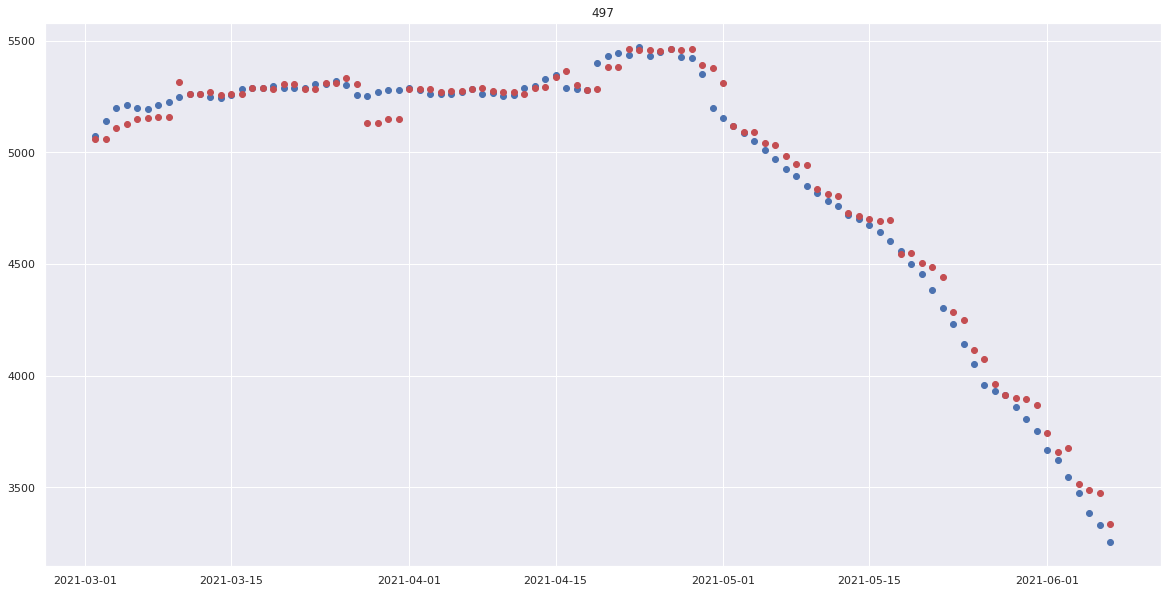

In [147]:

plt.figure(figsize=(20, 10))
plt.plot(val.date, val['qty'], 'o', val.date, val['pre_qty'], 'ro')
plt.title("497")
plt.show()

## 3.2 LightGBM

In [34]:
import lightgbm as lgb
from lightgbm import plot_importance

In [36]:

# 构造训练集
dtrain = lgb.Dataset(X_train,y_train)
dtest = lgb.Dataset(X_test,y_test)

print(dtrain)

In [38]:
params = {
    'booster': 'gbtree',
    'objective': 'regression',
    'num_leaves': 31,
    'subsample': 0.8,
    'bagging_freq': 1,
    'feature_fraction ': 0.8,
    'slient': 1,
    'learning_rate ': 0.1,
    'seed': 0
}

num_rounds = 500

# xgboost模型训练
lgbmodel = lgb.train(params,dtrain, num_rounds, valid_sets=[dtrain, dtest], 
                  verbose_eval=100, early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.402619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8981
[LightGBM] [Info] Number of data points in the train set: 275311, number of used features: 44
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Info] Start training from score 7.062420
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00480988	valid_1'

In [39]:
# 对测试集进行预测
pre_lgb = lgbmodel.predict(X_test)

In [40]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# mape = mape(np.expm1(y_test.reshape(-1)), np.expm1(pre))
# print("MAPE is: {}".format(mape))

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_norm = mean_absolute_error(y_test.values, pre_lgb)  # 归一化后的值
mae = mean_absolute_error(np.expm1(y_test.values), np.expm1(pre_lgb))


rmse = np.sqrt(mean_squared_error(np.expm1(y_test.values), np.expm1(pre_lgb)))

print("mae:",mae_norm)
print("mae:",mae)
print("rmse:",rmse)


mae: 0.018923955297323495
mae: 81.15812502488455
rmse: 307.6095513832293


<Figure size 1440x720 with 0 Axes>

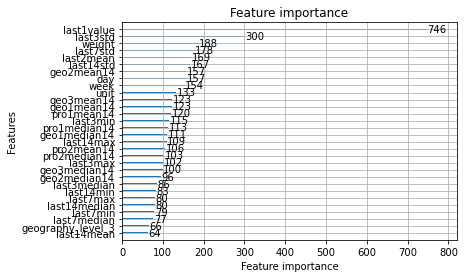

In [46]:
# 显示重要特征
plt.figure(figsize=(20,10))
plot_importance(lgbmodel, max_num_features=30)
plt.show()

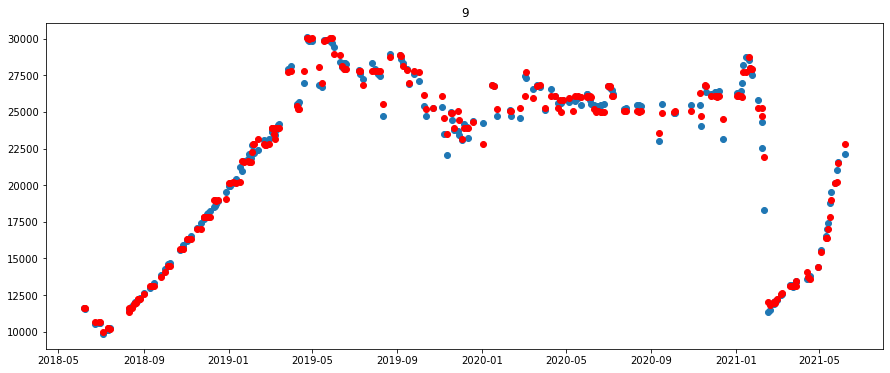

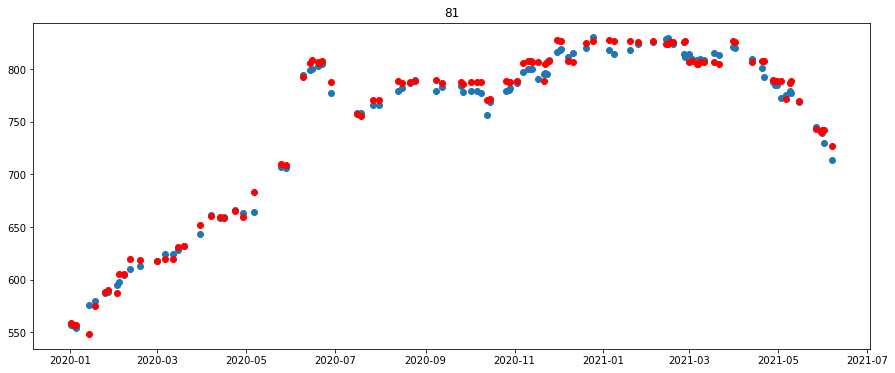

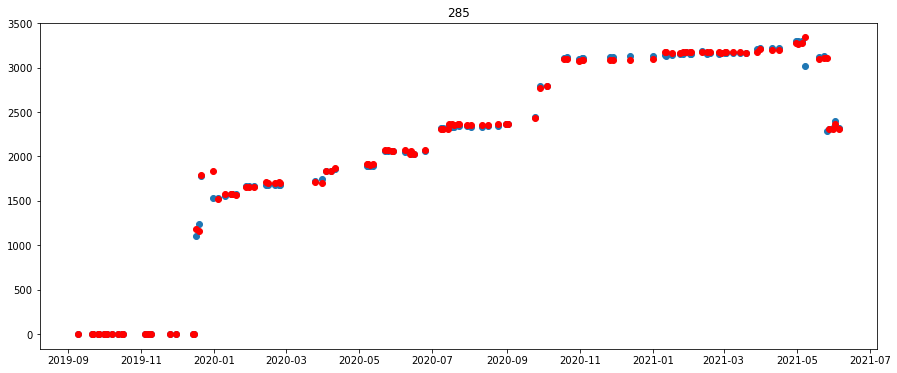

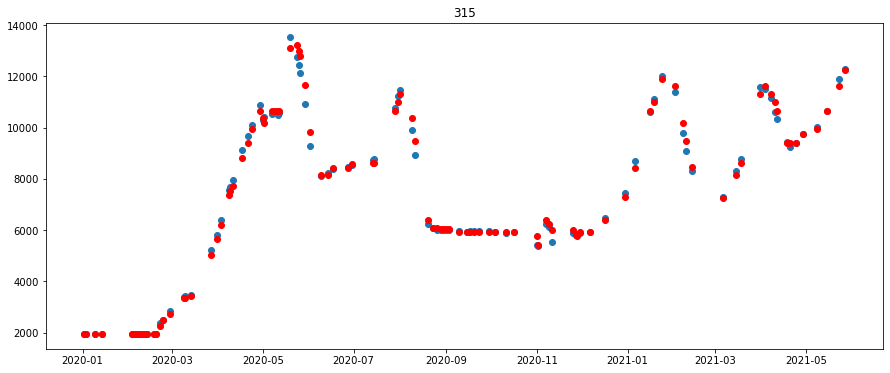

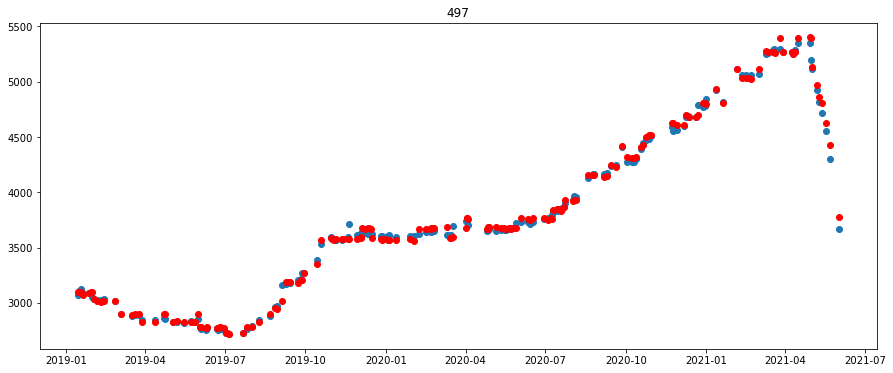

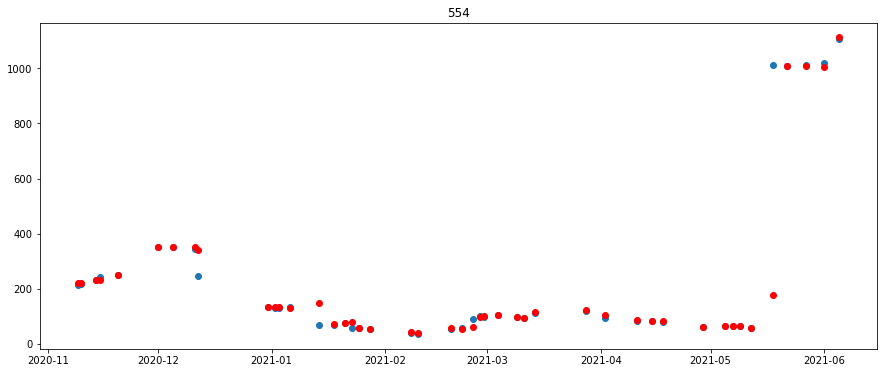

""


In [48]:
# plot the model result

data = X_test.copy()
data['qty'] = np.expm1(y_test)
data['pre_qty'] = np.expm1(pre_lgb)

data.groupby('unit').apply(date_trend)

In [52]:
prev = data[['qty', 'pre_qty']].copy()
prev['xgb_pre_qty'] = np.expm1(pre)
prev

,qty,pre_qty,xgb_pre_qty
328733,17350.229492,17050.775870,17381.859375
571375,1318.336046,1315.011795,1337.043335
504732,53285.144800,54809.753678,53362.332031
572271,391.000000,395.998578,389.578491
100498,8023.032800,7925.544866,7982.210938
...,...,...,...
595222,362.666667,360.837127,361.036011
548035,7899.236654,7878.007697,7897.741211
371998,9151.666667,9143.002585,9188.644531
517264,385.833333,389.723144,387.882538


## 3.3 autox


In [ ]:
# 使用了xgboost 和 lightgbm两者之间进行了融合

# 模型预测
predict_lgb = model_lgb.predict(test, used_features)
predict_xgb = model_xgb.predict(test, used_features)
# predict_cat = model_cat.predict(test, used_features)
# predict_tabnet = model_tabnet.predict(test[used_features])
# predict = (predict_xgb + predict_lgb + predict_cat) / 3
predict = (predict_xgb * 0.5 + predict_lgb * 0.5)



## 3.4 ARIMA

- 1 使用ARIMA 训练样本 train [2018/6/4 - 2021/3/1]， 分成不同的unit, 分别预测 train [2018/6/4 - 2021/3/1] 的结果
- 2 由于有的unit会存在 在训练集中该时间段NaN，于是不考虑这些值。
- 3 用真是值 - 预测值，然后下游利用 xgboos等模型做回归。